### Первый A/B тест
Сравнение средних значений (t-test)

#### Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Описание данных
 * order_id - id заказа
 * delivery_time - время доставки в минутах
 * district - район доставки
 * experiment_group - экспериментальная группа

Задачи:
1. Выдвинуть гипотезы, которые мы можем проверить на этом эксперименте
2. Построить графики распределения времени доставки по экспериментальным группам
3. Проверить нормальность выборок
4. Сравнить среднее время доставки в тестовой и контрольной группах
5. Посчитать, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлить до сотых)?
6. Принять решение, выкатываем ли новый алгоритм для всех курьеров доставки?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests
import json 
import os

In [4]:
public_url = "https://disk.yandex.ru/d/l7RSVjrz_a3GJg"

save_folder = r"C:\Users\User\notebooks\analytic_karpov\статистика\datasets"
os.makedirs(save_folder, exist_ok=True)  

download_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_url}"
response = requests.get(download_url)
download_link = response.json()["href"]

file_name = "pizza_delivery.csv"  
save_path = os.path.join(save_folder, file_name)

with open(save_path, "wb") as file:
    file.write(requests.get(download_link).content)

print(f"Файл загружен в {save_path}")


Файл загружен в C:\Users\User\notebooks\analytic_karpov\статистика\datasets\pizza_delivery.csv


In [47]:
data_pizza = pd.read_csv(save_path)
data_pizza.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


1. Выдвинуть гипотезы, которые мы можем проверить на этом эксперименте


 - Нулевая гипотеза: H0 - разница между средним временем в тестовой и контрольной группе НЕТ
 - Альтернативная гипотеза: H1 - разница между средним временем в тестовой и контрольной группе ЕСТЬ

 Проверять будем через t-test

2. Построить графики распределения времени доставки по экспериментальным группам


In [48]:
data_pizza_test = data_pizza[data_pizza["experiment_group"] == "test"]["delivery_time"]
data_pizza_control = data_pizza[data_pizza["experiment_group"] == "control"]["delivery_time"]

In [49]:
data_pizza_test

10092    38.0
10093    31.0
10094    39.0
10095    29.0
10096    31.0
         ... 
20191    42.0
20192    32.0
20193    23.0
20194    41.0
20195    41.0
Name: delivery_time, Length: 10104, dtype: float64

In [50]:
data_pizza_control

0        44.0
1        51.0
2        46.0
3        34.0
4        43.0
         ... 
10087    23.0
10088    45.0
10089    41.0
10090    38.0
10091    55.0
Name: delivery_time, Length: 10092, dtype: float64

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


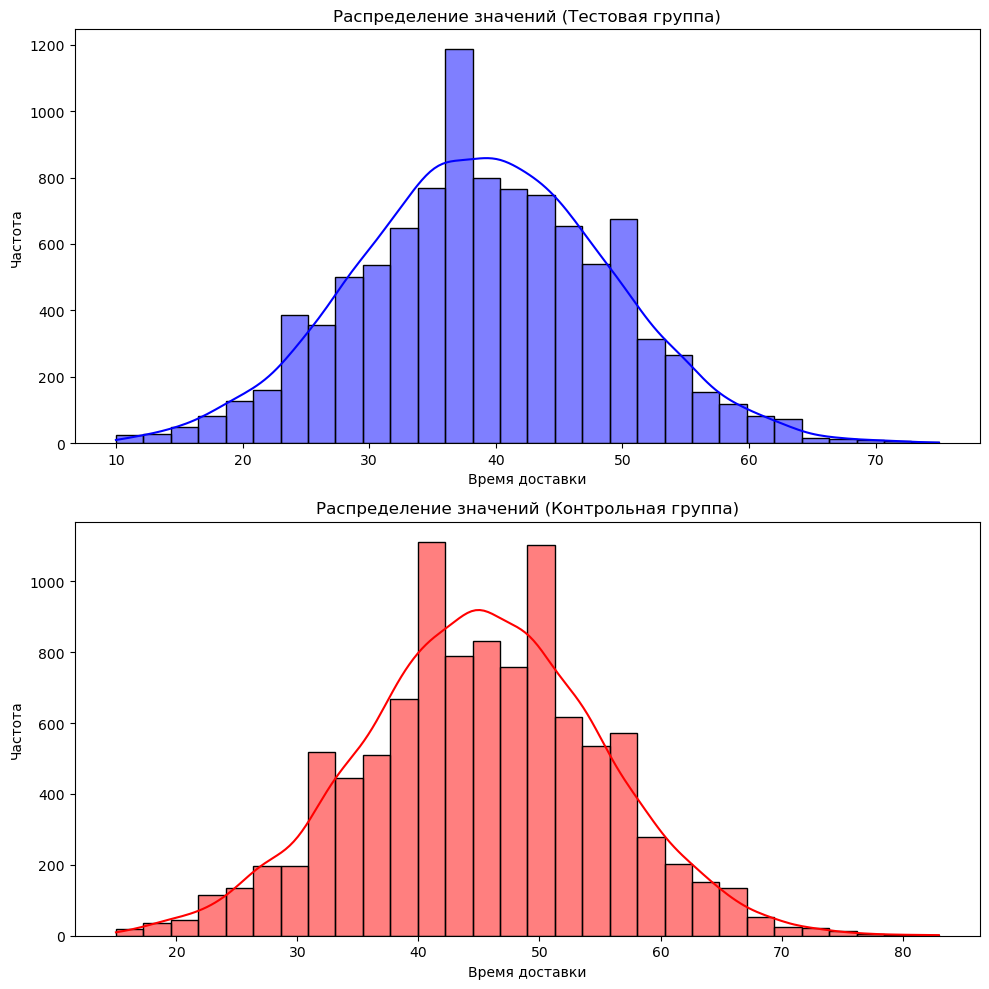

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

sns.histplot(data_pizza_test, bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Распределение значений (Тестовая группа)")
axes[0].set_xlabel("Время доставки")
axes[0].set_ylabel("Частота")

sns.histplot(data_pizza_control, bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Распределение значений (Контрольная группа)")
axes[1].set_xlabel("Время доставки")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

С первого взгляда можно сказать, что данные распределены нормально => унимодально, почти симметрично (колкообразная структура KDE линии)

Но нужно провести дополнительные проверки 

3. Проверить нормальность выборок


1. Графический - построим qq-plot

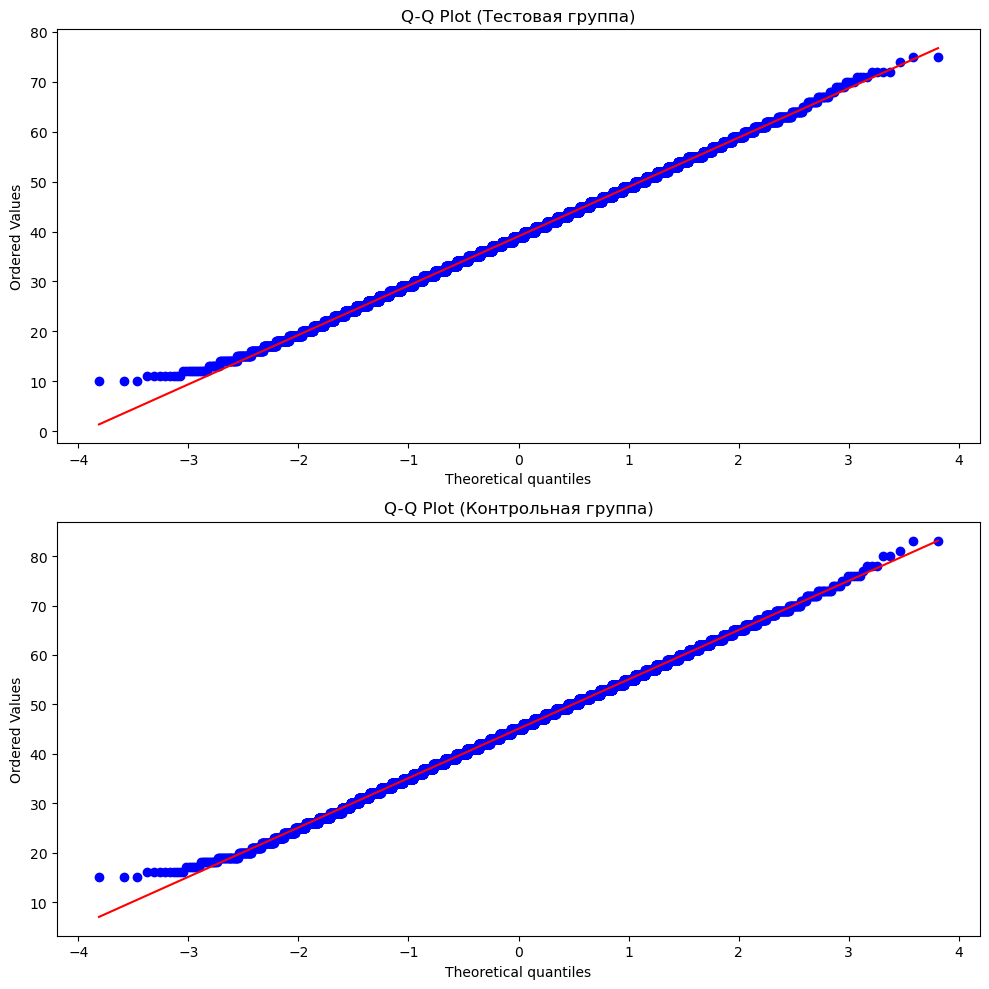

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

stats.probplot(data_pizza_test, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot (Тестовая группа)")

stats.probplot(data_pizza_control, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot (Контрольная группа)")

plt.tight_layout()
plt.show()

В обоих случаях отклонение от линии прямой точки лежат близко (кроме левых хвостов)

2. Статистический способ - тест Шапиро-Уилка

In [53]:
from scipy.stats import shapiro

Обязательно возьмём меньшее количество данных из выборок, ибо на больших данных критерий Ш-У может показывать неверные результаты.

In [54]:
stat_t, p_t = shapiro(data_pizza_test.sample(1000, random_state=17))
print(f"Значения для тестового набора: \
      \nзначения теста - {stat_t} \
      \np-value - {p_t}")

Значения для тестового набора:       
значения теста - 0.9975473880767822       
p-value - 0.14001426100730896


Поскольку p-value > 0.05 => данные нормально распределены для тестовой группы

In [59]:
stat_t, p_t = shapiro(data_pizza_control.sample(1000, random_state=17))
print(f"Значения для контрольного набора: \
      \nзначения теста - {stat_t} \
      \np-value - {p_t}")

Значения для контрольного набора:       
значения теста - 0.9974724054336548       
p-value - 0.12408281117677689


Поскольку p-value > 0.05 => данные нормально распределены для контрольной группы

4. Сравнить среднее время доставки в тестовой и контрольной группах


In [56]:
from scipy.stats import ttest_ind

In [57]:
stats.ttest_ind(data_pizza_test,
                data_pizza_control)

TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)

p-value < 0.05 => H0 можно опровергнуть

5. Посчитать, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округлить до сотых)?


In [58]:
mean_control = data_pizza_control.mean()
mean_test = data_pizza_test.mean()

percentage_change = ((mean_test - mean_control) / mean_control) * 100
np.round(percentage_change, 2)

-13.35

На 13% процентов уменьшилось количество времени в тестовом наборе - хороший результат

6. Принять решение, выкатываем ли новый алгоритм для всех курьеров доставки?


Да, поскольку уменьшилось на 13% время доставки 